In [1]:
# -*- coding: utf-8 -*-

In [2]:
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement=True)

#最多占gpu资源的70%
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.)

#开始不会给tensorflow全部gpu资源 而是按需增加
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


# 資料路徑
BASE_PATH = 'E:/git/3rd-ML100Days/D101-103/'

DATASET_PATH  = 'E:/git/3rd-ML100Days/D101-103/test'

OBJECT_NAME = 'NASNetLarge_model_12_27-1'

# 影像大小
IMAGE_SIZE = (331, 331)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 4

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = OBJECT_NAME+'.h5'

# 模型輸出儲存的檔案
WEIGHTS_FINAL_BASE = 'base_'+OBJECT_NAME+'.h5'

In [4]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))


Found 2265 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [5]:
from keras.callbacks import ModelCheckpoint,TensorBoard
output_model_file = BASE_PATH+'checkpoint/'+OBJECT_NAME+'checkpoint-{epoch:02d}e-val_acc_{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(output_model_file, monitor='val_acc', verbose=1, save_best_only=True)
RUN = RUN + 1 if 'RUN' in locals() else 1   # locals() 函數會以字典類型返回當前位置的全部局部變量。
LOG_DIR = BASE_PATH+'log/'+OBJECT_NAME+'training_logs/run{}'.format(RUN)
tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)

In [6]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = NASNetLarge (include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0][0]     

separable_conv_2_normal_left2_1 (None, 21, 21, 336)  121296      activation_148[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_right2_ (None, 21, 21, 336)  115920      activation_150[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_left5_1 (None, 21, 21, 336)  115920      activation_152[0][0]             
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 21, 21, 336)  1344        separable_conv_2_normal_left1_10[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 21, 21, 336)  1344        separable_conv_2_normal_right1_10
__________________________________________________________________________________________________
separable_

separable_conv_2_normal_left2_1 (None, 21, 21, 336)  121296      activation_160[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_right2_ (None, 21, 21, 336)  115920      activation_162[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_left5_1 (None, 21, 21, 336)  115920      activation_164[0][0]             
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 21, 21, 336)  1344        separable_conv_2_normal_left1_11[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 21, 21, 336)  1344        separable_conv_2_normal_right1_11
__________________________________________________________________________________________________
separable_

In [7]:
# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        callbacks=[tensorboard,checkpoint],
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
566/566 [==============================] - 902s 2s/step - loss: 1.2383 - acc: 0.5689 - val_loss: 0.5475 - val_acc: 0.8060

Epoch 00001: val_acc improved from -inf to 0.80600, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/NASNetLarge_model_12_27-1checkpoint-01e-val_acc_0.81.hdf5
Epoch 2/20
566/566 [==============================] - 828s 1s/step - loss: 0.7407 - acc: 0.7465 - val_loss: 0.4313 - val_acc: 0.8440

Epoch 00002: val_acc improved from 0.80600 to 0.84400, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/NASNetLarge_model_12_27-1checkpoint-02e-val_acc_0.84.hdf5
Epoch 3/20
566/566 [==============================] - 826s 1s/step - loss: 0.5402 - acc: 0.8158 - val_loss: 0.3786 - val_acc: 0.8640

Epoch 00003: val_acc improved from 0.84400 to 0.86400, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/NASNetLarge_model_12_27-1checkpoint-03e-val_acc_0.86.

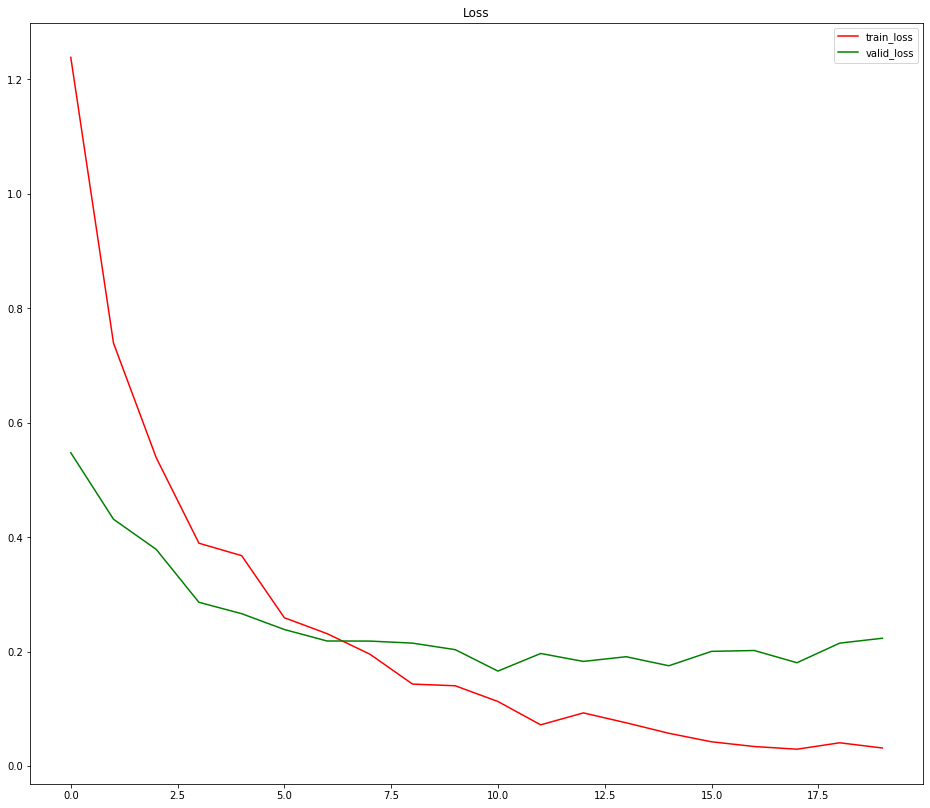

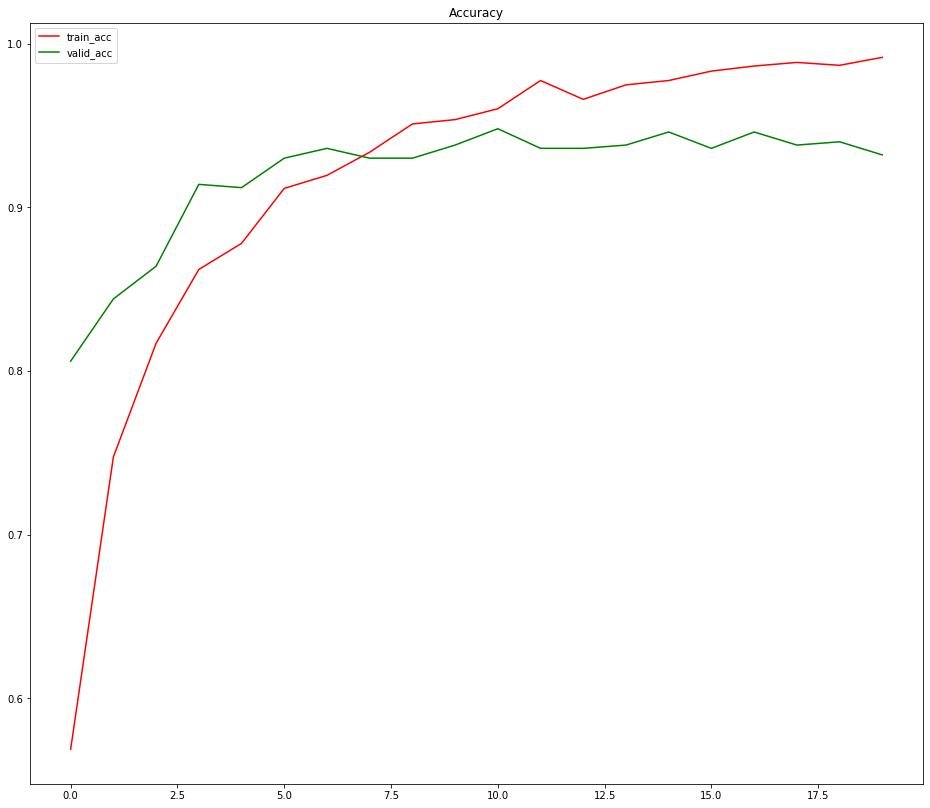

In [8]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()

In [16]:
net_final.compile(optimizer=SGD(lr=1e-5,momentum=0.9,decay=0.0001,nesterov=True),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        callbacks=[tensorboard,checkpoint],
                        epochs = NUM_EPOCHS)

Epoch 1/20
290/290 [==============================] - 185s 638ms/step - loss: 1.0734 - acc: 0.6303 - val_loss: 0.9579 - val_acc: 0.7175

Epoch 00001: val_acc improved from 0.60163 to 0.71748, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/DenseNet201_model_12_26-1checkpoint-01e-val_acc_0.72.hdf5
Epoch 2/20
290/290 [==============================] - 161s 555ms/step - loss: 0.9589 - acc: 0.6724 - val_loss: 0.8354 - val_acc: 0.7581

Epoch 00002: val_acc improved from 0.71748 to 0.75813, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/DenseNet201_model_12_26-1checkpoint-02e-val_acc_0.76.hdf5
Epoch 3/20
290/290 [==============================] - 165s 570ms/step - loss: 0.8724 - acc: 0.7187 - val_loss: 0.7452 - val_acc: 0.7846

Epoch 00003: val_acc improved from 0.75813 to 0.78455, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/DenseNet201_model_12_26-1checkpoint-03e-val_acc_0.78.hdf5
Epoch 4/20
290/290 [==============================] - 164s 564ms/step - loss: 0

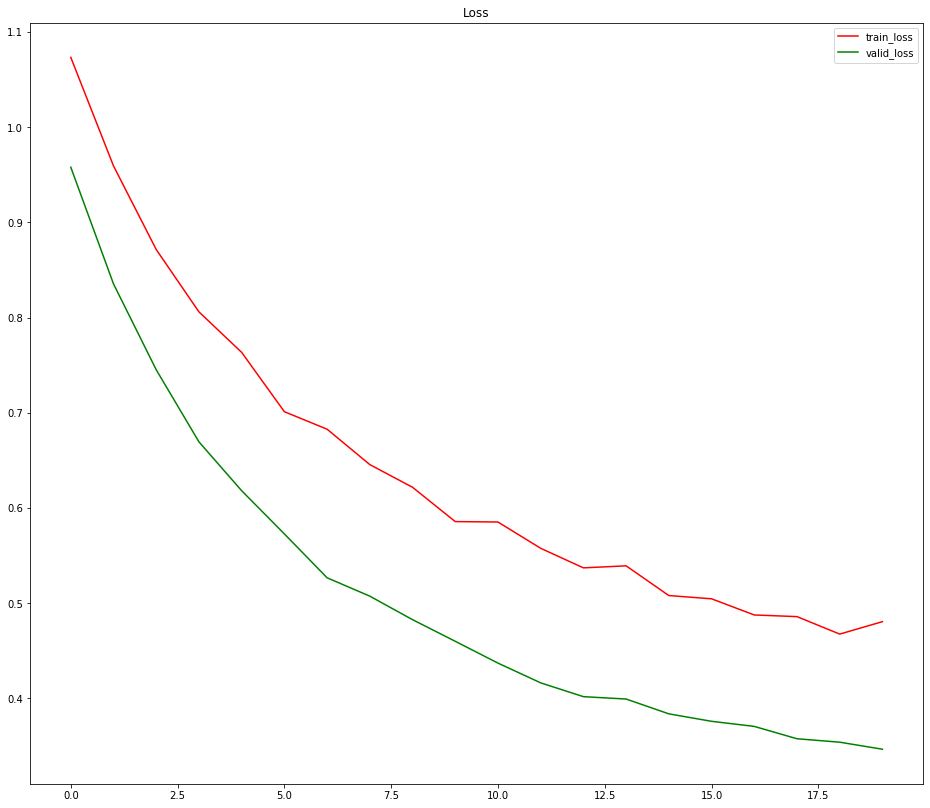

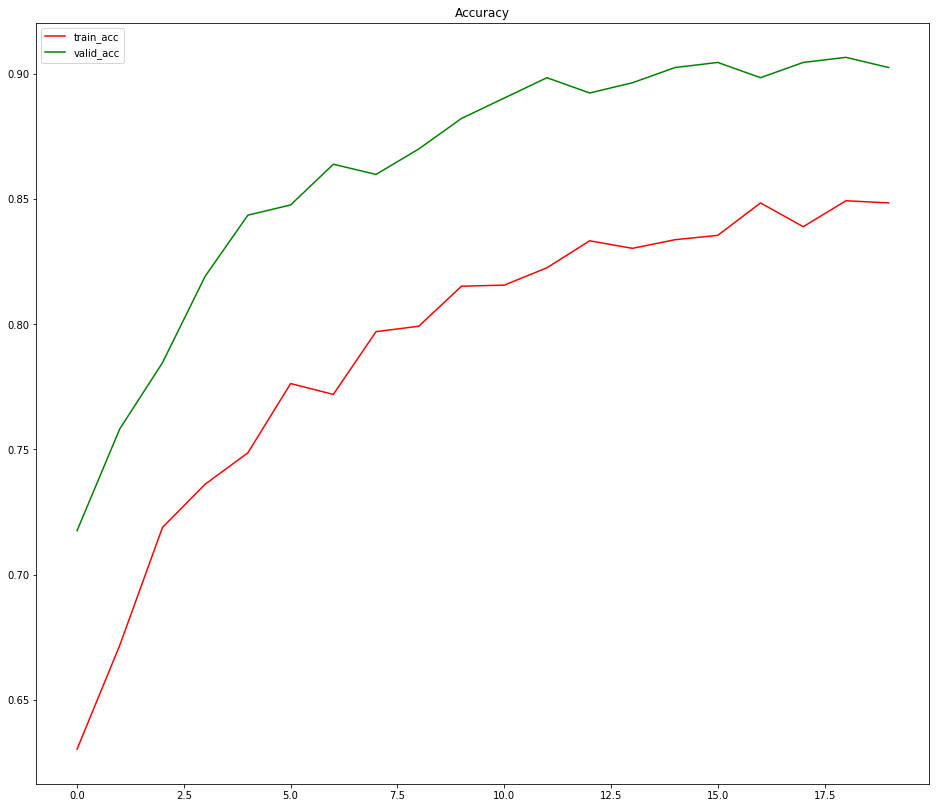

In [17]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()

In [18]:
# 訓練模型
NUM_EPOCHS=5
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        callbacks=[tensorboard,checkpoint],
                        epochs = NUM_EPOCHS)

Epoch 1/5
290/290 [==============================] - 158s 544ms/step - loss: 0.4581 - acc: 0.8476 - val_loss: 0.3414 - val_acc: 0.9024

Epoch 00001: val_acc did not improve from 0.90650
Epoch 2/5
290/290 [==============================] - 158s 544ms/step - loss: 0.4637 - acc: 0.8473 - val_loss: 0.3355 - val_acc: 0.9126

Epoch 00002: val_acc improved from 0.90650 to 0.91260, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/DenseNet201_model_12_26-1checkpoint-02e-val_acc_0.91.hdf5
Epoch 3/5
290/290 [==============================] - 159s 549ms/step - loss: 0.4576 - acc: 0.8557 - val_loss: 0.3210 - val_acc: 0.9167

Epoch 00003: val_acc improved from 0.91260 to 0.91667, saving model to E:/git/3rd-ML100Days/D101-103/checkpoint/DenseNet201_model_12_26-1checkpoint-03e-val_acc_0.92.hdf5
Epoch 4/5
290/290 [==============================] - 160s 552ms/step - loss: 0.4601 - acc: 0.8428 - val_loss: 0.3176 - val_acc: 0.9146

Epoch 00004: val_acc did not improve from 0.91667
Epoch 5/5
290/29

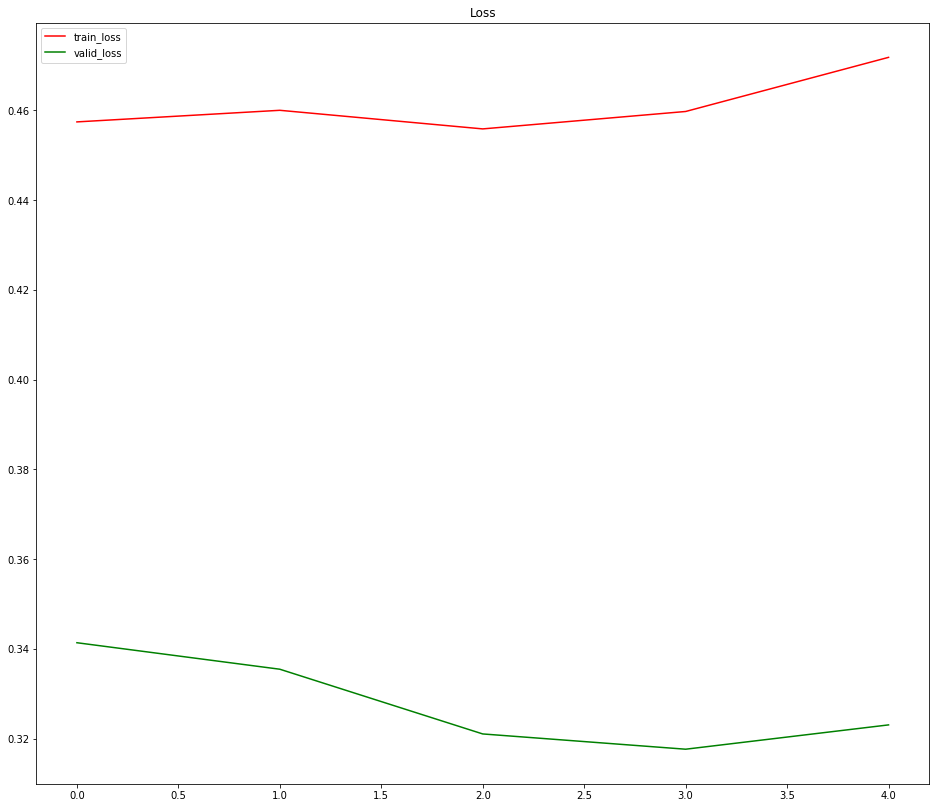

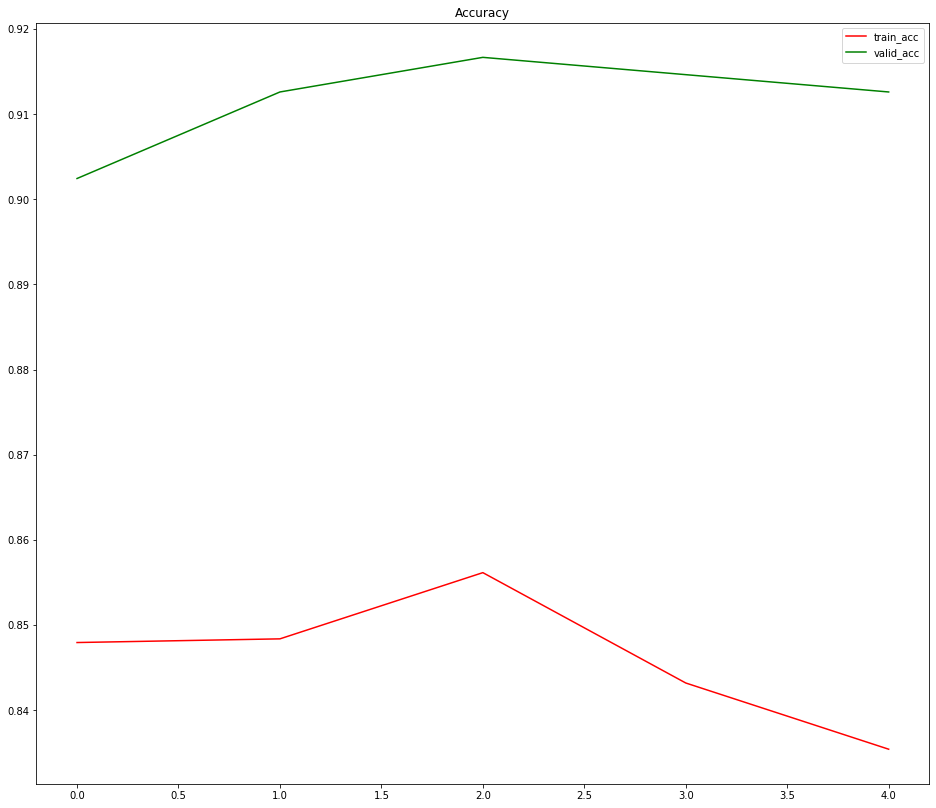

In [19]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()